In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.path as mplPath
from matplotlib import pyplot
import geopandas as gpd
import pandas as pd
import cartopy.io.shapereader as shpreader
import geodatasets
import xarray as xr
import numpy as np
from geopandas import GeoSeries
from pathlib import Path
from pyproj import Transformer
from shapely.geometry import Point , Polygon, MultiPolygon
from shapely.geometry.multipolygon import MultiPolygon
import shapely.wkt
import shapely.geometry
import shapely
from shapely.ops import nearest_points
from pathlib import Path
import rasterio
import rioxarray

C:\Users\basna\AppData\Roaming\Python\Python311\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


                 lon        lat     elv                   geometry
0          97.252145  20.552498  1000.0  POINT (97.25215 20.55250)
1          97.252145  20.549998  1000.0  POINT (97.25215 20.55000)
2          97.252145  20.547498  1000.0  POINT (97.25215 20.54750)
3          97.252145  20.544998  1000.0  POINT (97.25215 20.54500)
4          97.252145  20.542498  1000.0  POINT (97.25215 20.54250)
...              ...        ...     ...                        ...
20405497  105.731728   5.529998  1000.0  POINT (105.73173 5.53000)
20405498  105.731728   5.527498  1000.0  POINT (105.73173 5.52750)
20405499  105.731728   5.524998  1000.0  POINT (105.73173 5.52500)
20405500  105.731728   5.522498  1000.0  POINT (105.73173 5.52250)
20405501  105.731728   5.520415  1000.0  POINT (105.73173 5.52041)

[20405502 rows x 4 columns]
<xarray.Dataset>
Dimensions:  (lon: 3393, lat: 6014)
Coordinates:
  * lon      (lon) float64 97.25 97.25 97.26 97.26 ... 105.7 105.7 105.7 105.7
  * lat      (lat) flo

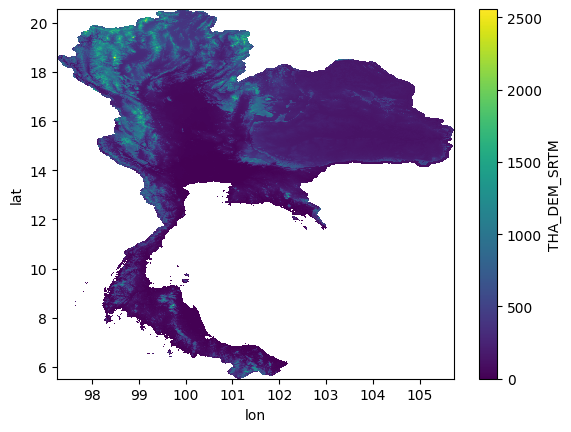

In [2]:
elv = rioxarray.open_rasterio('Data\\\THAILAND_SRTM\\\THAILAND\\tha_dem_srtm\\w001001.adf',masked=True)
xr_elv = elv.coarsen(x = 3, y= 3, boundary='pad').mean()

xr_elv = xr_elv.sel(band = 1)
xr_elv = xr_elv.drop_vars('band')
xr_elv = xr_elv.drop('spatial_ref', dim=None)
xr_elv = xr_elv.rename({'x':'lon'})
xr_elv = xr_elv.rename({'y':'lat'})
xr_elv = xr_elv.to_dataset(name='elv')
df_elv = xr_elv.to_dataframe()
df_elv.reset_index(inplace=True)
df_elv = gpd.GeoDataFrame(df_elv, geometry =gpd.points_from_xy(df_elv['lon'],df_elv['lat']))
df_elv.crs = {'init': 'epsg:4326'}
df_elv['elv'] = df_elv['elv'].fillna(1000)
print(df_elv)

xr_elv['elv'].plot()
print(xr_elv)

In [3]:
xr_landuse_suitability_index = xr.open_dataset('Output\\xr_SI_Landcover.nc')
df_slope_suitability_index = xr_landuse_suitability_index.to_dataframe()
df_slope_suitability_index.reset_index(inplace=True)
df_slope_suitability_index = gpd.GeoDataFrame(df_slope_suitability_index, geometry =gpd.points_from_xy(df_slope_suitability_index['lon'],df_slope_suitability_index['lat']))
df_slope_suitability_index.crs = {'init': 'epsg:4326'}
df_slope_suitability_index['SI_BGEC'] = 0
df_slope_suitability_index['SI_Biomass'] = 0
df_slope_suitability_index['SI_Solar'] = 0
df_slope_suitability_index['SI_Wind'] = 0
df_slope_suitability_index['SI_BGWW'] = 0
df_slope_suitability_index['SI_MSW'] = 0
df_slope_suitability_index['SI_IEW'] = 0
print(df_slope_suitability_index)

C:\Users\basna\AppData\Roaming\Python\Python311\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


                lat         lon  lccs_class  SI_BGEC  SI_Biomass  SI_Solar  \
0          5.615278   97.345833           0        0           0         0   
1          5.615278   97.348611           0        0           0         0   
2          5.615278   97.351389           0        0           0         0   
3          5.615278   97.354167           0        0           0         0   
4          5.615278   97.356944           0        0           0         0   
...             ...         ...         ...      ...         ...       ...   
15957805  20.462500  105.623611           0        0           0         0   
15957806  20.462500  105.626389           0        0           0         0   
15957807  20.462500  105.629167           0        0           0         0   
15957808  20.462500  105.631944           0        0           0         0   
15957809  20.462500  105.634722           0        0           0         0   

          SI_Wind  SI_BGWW  SI_MSW  SI_IEW    ADM1_EN  A_BGEC  

In [4]:
df_slope_suitability_index = gpd.sjoin_nearest(df_slope_suitability_index,df_elv,how='left')

for i in df_slope_suitability_index.columns:
    if i not in (['lon_left','lat_left','geometry','elv','SI_BGEC','SI_Biomass','SI_Solar','SI_Wind','SI_BGWW','SI_MSW','SI_IEW']):
        df_slope_suitability_index = df_slope_suitability_index.drop(columns=i)

df_slope_suitability_index = df_slope_suitability_index.rename(columns= {'lon_left' : 'lon'})
df_slope_suitability_index = df_slope_suitability_index.rename(columns= {'lat_left' : 'lat'})
df_slope_suitability_index['elv']= df_slope_suitability_index['elv'].fillna(1000)

print(df_slope_suitability_index)

C:\Users\basna\AppData\Roaming\Python\Python311\site-packages\geopandas\array.py:364: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


                lat         lon  SI_BGEC  SI_Biomass  SI_Solar  SI_Wind  \
0          5.615278   97.345833        0           0         0        0   
1          5.615278   97.348611        0           0         0        0   
2          5.615278   97.351389        0           0         0        0   
3          5.615278   97.354167        0           0         0        0   
4          5.615278   97.356944        0           0         0        0   
...             ...         ...      ...         ...       ...      ...   
15957805  20.462500  105.623611        0           0         0        0   
15957806  20.462500  105.626389        0           0         0        0   
15957807  20.462500  105.629167        0           0         0        0   
15957808  20.462500  105.631944        0           0         0        0   
15957809  20.462500  105.634722        0           0         0        0   

          SI_BGWW  SI_MSW  SI_IEW                    geometry     elv  
0               0       0  

In [ ]:
## SI_BGEC ##
df_slope_suitability_index['SI_BGEC'].loc[df_slope_suitability_index['elv'] > 200] = 0
df_slope_suitability_index['SI_BGEC'].loc[(df_slope_suitability_index['elv'] > 150) & (df_slope_suitability_index['elv'] <= 200)] = 1
df_slope_suitability_index['SI_BGEC'].loc[(df_slope_suitability_index['elv'] > 50) & (df_slope_suitability_index['elv'] <= 150)] = 2
df_slope_suitability_index['SI_BGEC'].loc[df_slope_suitability_index['elv'] <= 50 ] = 3

## SI_Biomass ##
df_slope_suitability_index['SI_Biomass'].loc[df_slope_suitability_index['elv'] > 200] = 0
df_slope_suitability_index['SI_Biomass'].loc[(df_slope_suitability_index['elv'] > 150) & (df_slope_suitability_index['elv'] <= 200)] = 1
df_slope_suitability_index['SI_Biomass'].loc[(df_slope_suitability_index['elv'] > 50) & (df_slope_suitability_index['elv'] <= 150)] = 2
df_slope_suitability_index['SI_Biomass'].loc[df_slope_suitability_index['elv'] <= 50 ] = 3

## SI for Solar ##
df_slope_suitability_index['SI_Solar'].loc[df_slope_suitability_index['elv'] > 200] = 0
df_slope_suitability_index['SI_Solar'].loc[(df_slope_suitability_index['elv'] > 150) & (df_slope_suitability_index['elv'] <= 200)] = 1
df_slope_suitability_index['SI_Solar'].loc[(df_slope_suitability_index['elv'] > 50) & (df_slope_suitability_index['elv'] <= 150)] = 2
df_slope_suitability_index['SI_Solar'].loc[df_slope_suitability_index['elv'] <= 50 ] = 3

## SI_Wind ##
df_slope_suitability_index['SI_Wind'].loc[df_slope_suitability_index['elv'] > 200] = 0
df_slope_suitability_index['SI_Wind'].loc[(df_slope_suitability_index['elv'] > 150) & (df_slope_suitability_index['elv'] <= 200)] = 1
df_slope_suitability_index['SI_Wind'].loc[(df_slope_suitability_index['elv'] > 50) & (df_slope_suitability_index['elv'] <= 150)] = 2
df_slope_suitability_index['SI_Wind'].loc[df_slope_suitability_index['elv'] <= 50 ] = 3

## SI_BGWW ##
df_slope_suitability_index['SI_BGWW'].loc[df_slope_suitability_index['elv'] > 200] = 0
df_slope_suitability_index['SI_BGWW'].loc[(df_slope_suitability_index['elv'] > 150) & (df_slope_suitability_index['elv'] <= 200)] = 1
df_slope_suitability_index['SI_BGWW'].loc[(df_slope_suitability_index['elv'] > 50) & (df_slope_suitability_index['elv'] <= 150)] = 2
df_slope_suitability_index['SI_BGWW'].loc[df_slope_suitability_index['elv'] <= 50 ] = 3

## SI_MSW ##
df_slope_suitability_index['SI_MSW'].loc[df_slope_suitability_index['elv'] > 120] = 0
df_slope_suitability_index['SI_MSW'].loc[(df_slope_suitability_index['elv'] > 80) & (df_slope_suitability_index['elv'] <= 120)] = 1
df_slope_suitability_index['SI_MSW'].loc[(df_slope_suitability_index['elv'] > 49) & (df_slope_suitability_index['elv'] <= 80)] = 2
df_slope_suitability_index['SI_MSW'].loc[df_slope_suitability_index['elv'] <= 40 ] = 3

## SI_IEW ##
df_slope_suitability_index['SI_IEW'].loc[df_slope_suitability_index['elv'] > 120] = 0
df_slope_suitability_index['SI_IEW'].loc[(df_slope_suitability_index['elv'] > 80) & (df_slope_suitability_index['elv'] <= 120)] = 1
df_slope_suitability_index['SI_IEW'].loc[(df_slope_suitability_index['elv'] > 49) & (df_slope_suitability_index['elv'] <= 80)] = 2
df_slope_suitability_index['SI_IEW'].loc[df_slope_suitability_index['elv'] <= 40 ] = 3

print(df_slope_suitability_index)

C:\Users\basna\AppData\Local\Temp\ipykernel_10368\861201021.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_slope_suitability_index['SI_BGEC'].loc[df_slope_suitability_index['elv'] > 200] = 0
C:\Users\basna\AppData\Local\Temp\ipykernel_10368\861201021.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_slope_suitability_index['SI_BGEC'].loc[(df_slope_suitability_index['elv'] > 150) & (df_slope_suitability_index['elv'] <= 200)] = 1
C:\Users\basna\AppData\Local\Temp\ipykernel_10368\861201021.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the 

C:\Users\basna\AppData\Local\Temp\ipykernel_10368\861201021.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_slope_suitability_index['SI_Biomass'].loc[df_slope_suitability_index['elv'] > 200] = 0
C:\Users\basna\AppData\Local\Temp\ipykernel_10368\861201021.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_slope_suitability_index['SI_Biomass'].loc[(df_slope_suitability_index['elv'] > 150) & (df_slope_suitability_index['elv'] <= 200)] = 1
C:\Users\basna\AppData\Local\Temp\ipykernel_10368\861201021.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats 

                lat         lon  SI_BGEC  SI_Biomass  SI_Solar  SI_Wind  \
0          5.615278   97.345833        0           0         0        0   
1          5.615278   97.348611        0           0         0        0   
2          5.615278   97.351389        0           0         0        0   
3          5.615278   97.354167        0           0         0        0   
4          5.615278   97.356944        0           0         0        0   
...             ...         ...      ...         ...       ...      ...   
15957805  20.462500  105.623611        0           0         0        0   
15957806  20.462500  105.626389        0           0         0        0   
15957807  20.462500  105.629167        0           0         0        0   
15957808  20.462500  105.631944        0           0         0        0   
15957809  20.462500  105.634722        0           0         0        0   

          SI_BGWW  SI_MSW  SI_IEW                    geometry     elv  
0               0       0  

C:\Users\basna\AppData\Local\Temp\ipykernel_10368\861201021.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_slope_suitability_index['SI_IEW'].loc[(df_slope_suitability_index['elv'] > 49) & (df_slope_suitability_index['elv'] <= 80)] = 2
C:\Users\basna\AppData\Local\Temp\ipykernel_10368\861201021.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_slope_suitability_index['SI_IEW'].loc[df_slope_suitability_index['elv'] <= 40 ] = 3


In [ ]:
df_slope_suitability_index.reset_index(inplace=True)

try: 
    df_slope_suitability_index = df_slope_suitability_index.drop(columns=['geometry'])
except:
    None

df_slope_suitability_index = df_slope_suitability_index.groupby(['lat', 'lon']).agg('mean')
df_slope_suitability_index.reset_index(inplace=True)
df_slope_suitability_index = df_slope_suitability_index.set_index(['lat', 'lon'])
try: 
    df_slope_suitability_index = df_slope_suitability_index.drop(columns=['index','elv'])
except:
    df_slope_suitability_index = df_slope_suitability_index.drop(columns=['elv'])

xr_slope_suitability_index = xr.Dataset.from_dataframe(df_slope_suitability_index)
xr_slope_suitability_index.to_netcdf(path='Output\\xr_SI_Elevation.nc')
print(xr_slope_suitability_index)


<xarray.Dataset>
Dimensions:     (lat: 5346, lon: 2985)
Coordinates:
  * lat         (lat) float64 5.615 5.618 5.621 5.624 ... 20.46 20.46 20.46
  * lon         (lon) float64 97.35 97.35 97.35 97.35 ... 105.6 105.6 105.6
Data variables:
    SI_BGEC     (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Biomass  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Solar    (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Wind     (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_BGWW     (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_MSW      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_IEW      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0


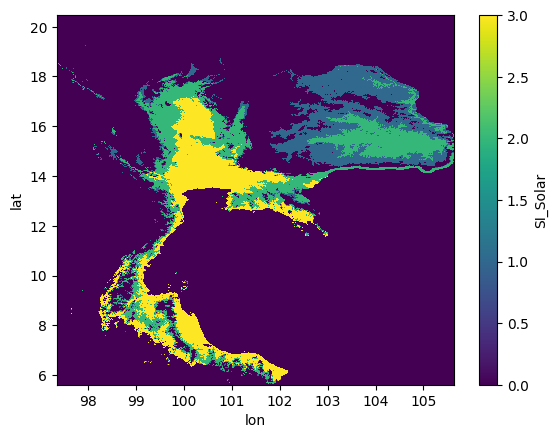

In [ ]:
xr_slope_suitability_index['SI_Solar'].plot()

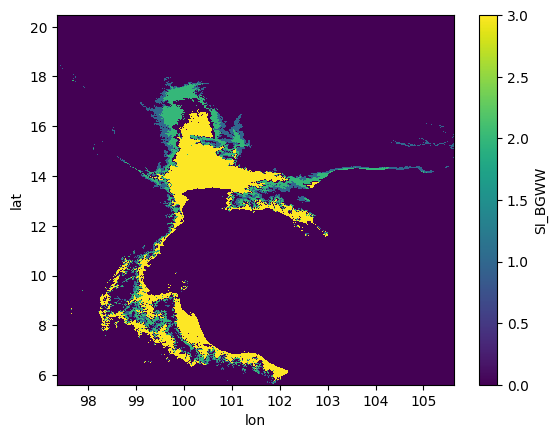

In [ ]:
xr_slope_suitability_index['SI_BGWW'].plot()